In [2]:
import pandas as pd

filename = 'abuse'

df = pd.read_csv('abuse.csv', sep=';')

n_impacts = len(df)
print(n_impacts, 'impacts')

df.head()

140 impacts


,Country,Val,Att
0,Afghanistan,46.0,78.0
1,Albania,13.0,5.0
2,Angola,38.0,25.0
3,Argentina,27.0,14.1
4,Armenia,10.0,3.7


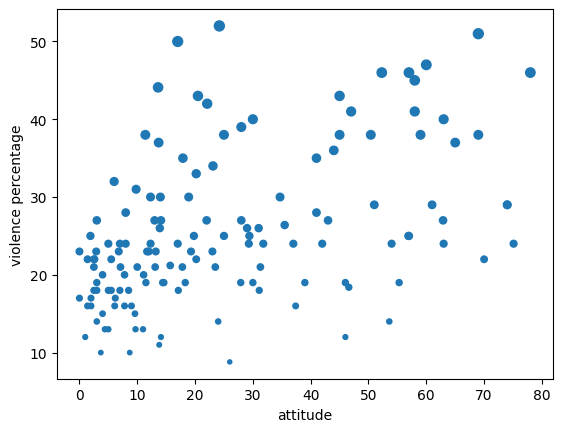

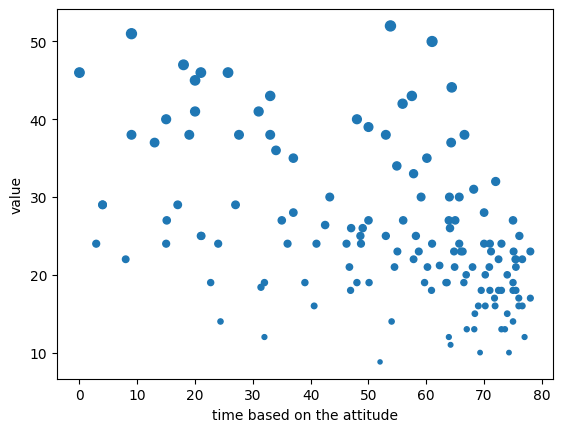

In [3]:
import matplotlib.pylab as plt

attitude = df['Att'].values
value = df['Val'].values

plt.scatter(attitude, value, s=value)
plt.xlabel('attitude')
plt.ylabel('violence percentage')
plt.show()

times_att = max(attitude) - attitude  #measure time from oldest crater (first impact) in data

plt.scatter(times_att, value, s=value)
plt.xlabel('time based on the attitude')
plt.ylabel('value')
plt.show()

In [4]:
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

In [5]:
attitude_per_beat = 5  #number of Att for each beat of music 

t_data = times_att/attitude_per_beat #rescale time from Myrs to beats


duration_beats = max(t_data)  #duration in beats (actually, onset of last note)
print('Duration:', duration_beats, 'beats')

Duration: 15.6 beats


Duration: 15.6 seconds


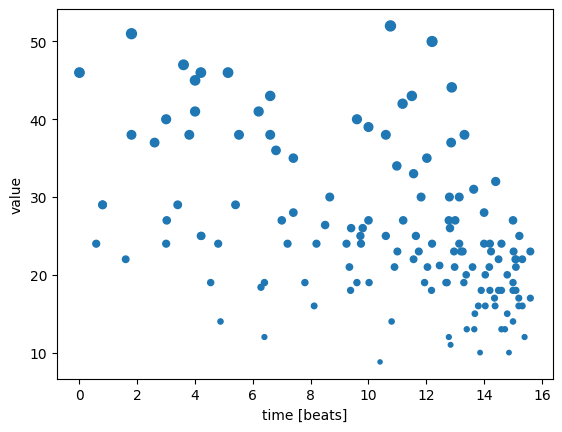

In [7]:
#calculate duration in seconds
bpm = 60  #if bpm = 60, 1 beat = 1 sec 
duration_sec = duration_beats*60/bpm #duration in seconds (actually, onset of last note)
print('Duration:', duration_sec, 'seconds')


plt.scatter(t_data, value, s=value)
plt.xlabel('time [beats]')
plt.ylabel('value')
plt.show()

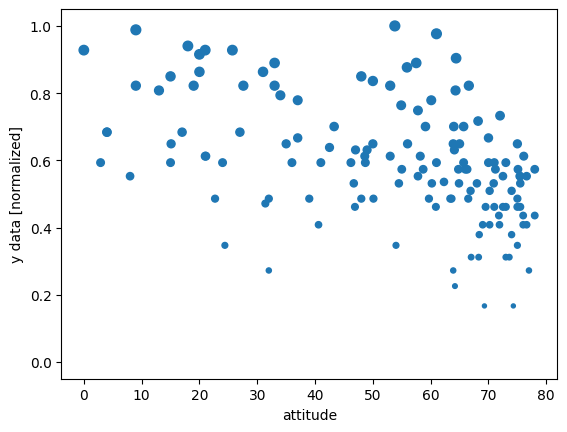

In [8]:
y_data = map_value(value, min(value), max(value), 0, 1) #normalize data, so it runs from 0 to 1 

y_scale = 0.5  #lower than 1 to spread out more evenly

y_data = y_data**y_scale

plt.scatter(times_att, y_data, s=50*y_data)
plt.xlabel('attitude')
plt.ylabel('y data [normalized]')
plt.show()

In [9]:
from audiolazy import str2midi #import function to convert note names to midi numbers (could also use: midi2str, str2freq, freq2str,freq2midi,midi2freq) https://pypi.org/project/audiolazy/

# 4 octaves of major scale
note_names = ['C2','D2','E2','F2','G2','A2','B2',
             'C3','D3','E3','F3','G3','A3','B3',
             'C4','D4','E4','F4','G4','A4','B4',
             'C5','D5','E5','F5','G5','A5','B5']

#4 octaves of major pentatonic scale 
note_names = ['C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4',
             'C5','D5','E5','G5','A5']

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names] #make a list of midi note numbers 

n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')

Resolution: 23 notes


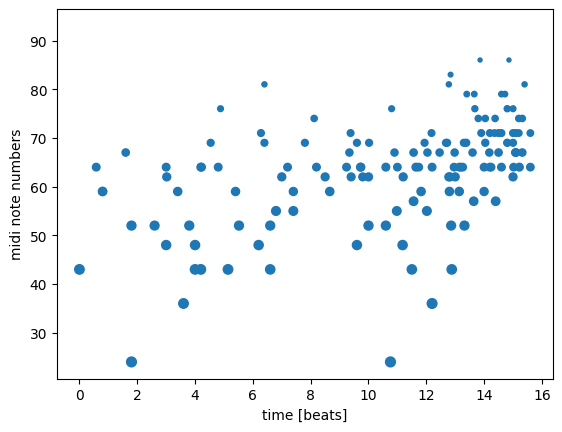

In [10]:
midi_data = []
for i in range(n_impacts):
    note_index = round(map_value(y_data[i], 0, 1, n_notes-1, 0)) #notice choice of polarity: bigger craters are mapped to lower notes
                                                        #we round the result because it's a list index which must be an integer
    midi_data.append(note_midis[note_index])

plt.scatter(t_data, midi_data, s=50*y_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

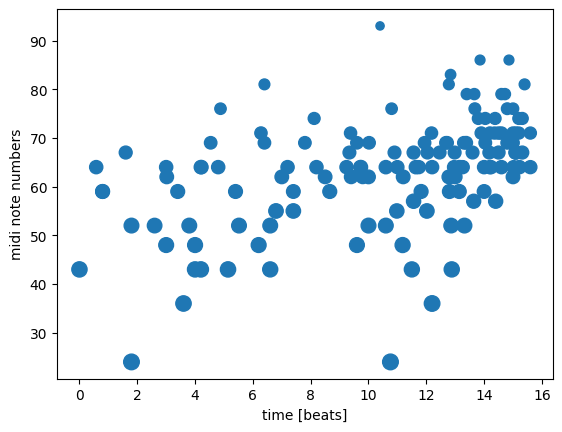

In [11]:
vel_min,vel_max = 35,127   #minimum and maximum note velocity

vel_data = []
for i in range(n_impacts):
    note_velocity = round(map_value(y_data[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
                                                                #we round here because note velocites are integers
    vel_data.append(note_velocity)
    
plt.scatter(t_data, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()


In [12]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/
    
#create midi file object, add tempo
my_midi_file = MIDIFile(1) #one track 
my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

#add midi notes
for i in range(n_impacts):
    my_midi_file.addNote(track=0, channel=0, pitch=midi_data[i], time=t_data[i], duration=2, volume=vel_data[i])

#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f) 

In [15]:
import sys
!{sys.executable} -m pip install --quiet "pygame"


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: /usr/local/bin/python3 -m pip install --upgrade pip


In [18]:
import pygame #import library for playing midi files, https://pypi.org/project/pygame/

pygame.init()
pygame.mixer.music.load(filename + '.mid')
pygame.mixer.music.play()

In [19]:
pygame.mixer.music.stop()